<!-- Credit Risk Scoring (Loan Default Prediction) -->
<!-- Problem: Bank wants to decide whether to approve/reject a loan.
Data: Borrower features → age, income, employment, loan amount, previous defaults.
Task: Predict default (1) or non-default (0). -->

## Credit Risk Scoring (Loan Default Prediction)

Problem: Bank wants to decide whether to approve/reject a loan.
Data: Borrower features → age, income, employment, loan amount, previous defaults.
Task: Predict default (1) or non-default (0).

Exploratory Data Analysis
1)Basic Dataset Overview
2)Understanding the target variable
3)Data Inspection
4)Univariate Analysis (Feature Distributions
5)Bivariate Analysis (Feature vs Target)
6)Correlation and Multicollinearity

1) Load & quick dataset overview (why: sanity check / detect immediate issues)

What to do: 
Load data.
Inspect rows, columns, types, missing counts, target distribution.

Why:
If data types are wrong, models will fail; if target is imbalanced you must handle it early

In [7]:
import pandas as pd
import numpy as np

RND = 42
df = pd.read_csv("Loan_default.csv")   
df.shape, df.columns.tolist()
df.head()
df.info()
df.describe(include='all').T

# Missing values & target distribution
print(df.isna().sum().sort_values(ascending=False).head(20))
print(df['Default'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

In [8]:
df

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255342,8C6S86ESGC,19,37979,210682,541,109,4,14.11,12,0.85,Bachelor's,Full-time,Married,No,No,Other,No,0
255343,98R4KDHNND,32,51953,189899,511,14,2,11.55,24,0.21,High School,Part-time,Divorced,No,No,Home,No,1
255344,XQK1UUUNGP,56,84820,208294,597,70,3,5.29,60,0.50,High School,Self-employed,Married,Yes,Yes,Auto,Yes,0
255345,JAO28CPL4H,42,85109,60575,809,40,1,20.90,48,0.44,High School,Part-time,Single,Yes,Yes,Other,No,0


In [11]:
# Why I picked those columns as “suspect”
# If data violates them → it’s almost certainly an error (garbage-in → garbage-out).

# Age: can’t be <18 (legal contract age), unlikely >100.

# Income: can’t be negative. If it’s 0, check whether it means “no income” or “missing”.

# LoanAmount: can’t be negative; unrealistic if e.g., >10 million in a consumer dataset.

# CreditScore: usually 300–850. Outside this range = invalid unless explicitly explained by dataset.

# MonthsEmployed: can’t be negative; >600 months (~50 years) might be possible but unusual.

# NumCreditLines: 0 is fine, but 200 would be weird → likely bad record.

# InterestRate: can’t be negative; >100% rare in regulated financial systems.

# LoanTerm: must be positive; if in months, usually 6–360.

# DTIRatio (Debt-to-Income): normally 0–1.5. Values >3–5 mean “debt > 300–500% of income” → almost always junk.

# So these checks are domain-driven sanity filters, not arbitrary 

In [12]:
def sanity_scan(df):
    problems = {}
    
    # numeric columns
    for col in df.select_dtypes(include=['int64','float64']).columns:
        if df[col].min() < 0 and col not in ["DTIRatio"]:  # negative check
            problems[col] = f"Negative values found: min={df[col].min()}"
        if df[col].nunique() < 5:
            problems[col] = f"Very few unique values: {df[col].unique()}"
    
    # categorical columns
    for col in df.select_dtypes(include=['object']).columns:
        n_unique = df[col].nunique()
        if n_unique > 50:
            problems[col] = f"Too many categories ({n_unique})"
    
    return problems

print(sanity_scan(df))


{'NumCreditLines': 'Very few unique values: [4 1 3 2]', 'Default': 'Very few unique values: [0 1]', 'LoanID': 'Too many categories (255347)'}


In [13]:
df.columns

Index(['LoanID', 'Age', 'Income', 'LoanAmount', 'CreditScore',
       'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm',
       'DTIRatio', 'Education', 'EmploymentType', 'MaritalStatus',
       'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner',
       'Default'],
      dtype='object')

In [14]:
report = {}

for col in df.columns:
    unique_vals = df[col].nunique()
    dtype = df[col].dtype

    if unique_vals == df.shape[0]:
        report[col] = "Drop (ID-like)"
    elif unique_vals == 1:
        report[col] = "Drop (constant)"
    elif unique_vals < 10 and dtype in ["int64","float64"]:
        report[col] = f"Suspicious numeric (few unique values: {df[col].unique()})"
    else:
        report[col] = "Keep"

import pprint
pprint.pprint(report)


{'Age': 'Keep',
 'CreditScore': 'Keep',
 'DTIRatio': 'Keep',
 'Default': 'Suspicious numeric (few unique values: [0 1])',
 'Education': 'Keep',
 'EmploymentType': 'Keep',
 'HasCoSigner': 'Keep',
 'HasDependents': 'Keep',
 'HasMortgage': 'Keep',
 'Income': 'Keep',
 'InterestRate': 'Keep',
 'LoanAmount': 'Keep',
 'LoanID': 'Drop (ID-like)',
 'LoanPurpose': 'Keep',
 'LoanTerm': 'Suspicious numeric (few unique values: [36 60 24 48 12])',
 'MaritalStatus': 'Keep',
 'MonthsEmployed': 'Keep',
 'NumCreditLines': 'Suspicious numeric (few unique values: [4 1 3 2])'}


In [15]:
df

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255342,8C6S86ESGC,19,37979,210682,541,109,4,14.11,12,0.85,Bachelor's,Full-time,Married,No,No,Other,No,0
255343,98R4KDHNND,32,51953,189899,511,14,2,11.55,24,0.21,High School,Part-time,Divorced,No,No,Home,No,1
255344,XQK1UUUNGP,56,84820,208294,597,70,3,5.29,60,0.50,High School,Self-employed,Married,Yes,Yes,Auto,Yes,0
255345,JAO28CPL4H,42,85109,60575,809,40,1,20.90,48,0.44,High School,Part-time,Single,Yes,Yes,Other,No,0


In [16]:
# Drop ID column
df = df.drop(columns=["LoanID"])

# Separate target
y = df["Default"]
X = df.drop(columns=["Default"])

# Convert suspicious numeric to categorical
categorical_cols = ["LoanTerm", "NumCreditLines",
                    "Education", "EmploymentType", "MaritalStatus",
                    "HasMortgage", "HasDependents", "LoanPurpose", "HasCoSigner"]

# Ensure they are dtype 'category'
for col in categorical_cols:
    X[col] = X[col].astype("category")

print("Cleaned dataset ready")
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


✅ Cleaned dataset ready
Shape of X: (255347, 16)
Shape of y: (255347,)


In [17]:
X

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner
0,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes
1,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes
2,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No
3,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No
4,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255342,19,37979,210682,541,109,4,14.11,12,0.85,Bachelor's,Full-time,Married,No,No,Other,No
255343,32,51953,189899,511,14,2,11.55,24,0.21,High School,Part-time,Divorced,No,No,Home,No
255344,56,84820,208294,597,70,3,5.29,60,0.50,High School,Self-employed,Married,Yes,Yes,Auto,Yes
255345,42,85109,60575,809,40,1,20.90,48,0.44,High School,Part-time,Single,Yes,Yes,Other,No


Target distribution (counts):
Default
0    225694
1     29653
Name: count, dtype: int64

Target distribution (percentage):
Default
0    88.39
1    11.61
Name: proportion, dtype: float64


C:\Users\Nishok\AppData\Local\Temp\ipykernel_20056\4237474599.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


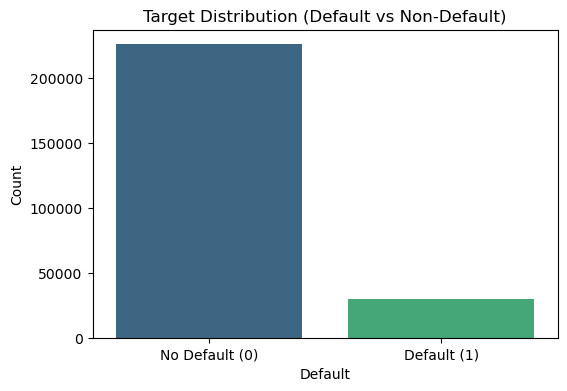

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check target distribution
class_counts = y.value_counts()
class_percent = y.value_counts(normalize=True) * 100

print("Target distribution (counts):")
print(class_counts)
print("\nTarget distribution (percentage):")
print(class_percent.round(2))

# Plot distribution
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.xticks([0,1], ["No Default (0)", "Default (1)"])
plt.ylabel("Count")
plt.title("Target Distribution (Default vs Non-Default)")
plt.show()


In [21]:
category_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols=X.select_dtypes(include=['number']).columns.tolist()
print(categorical_cols)
print(numerical_cols)

['LoanTerm', 'NumCreditLines', 'Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']
['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'InterestRate', 'DTIRatio']
